In [2]:
# Compute Metacoverage Matrices for selected Datasets, i.e. merged HeLa, iPS Org, c.ele samples

import sys
sys.path.insert(0,'/data/rajewsky/home/jaLLLes/code/gi_tailing')

import MetaCoverage
import GIAnalysis
import importlib
import collections

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import itertools
import pybedtools
import collections

from sklearn.preprocessing import quantile_transform

### Metacoverage Computation for FLAMSeq Datasets

a) Load .BED files with exons from GENOCODE<br>
b) Compute 'metaexon' annotation for human genome, i.e. form union if redundant and overlapping exons for each gene and export those to new .BED file<br>
c) Compute Coverage for MetaExon

Compare meta exon annotation for protein coding exons only

#### Input Datasets

In [2]:
# Define hg38 gencode exon bed path

gencode_hg38_exons_bed_path = '/data/murphy/home/jalles/projects/GItailing/annotation/gencode_v28_exon.bed'


In [1]:
# Define Genomic Clean BAM files

hela_merge_genomic_clean_bam_path = '/data/murphy/home/jalles/projects/GItailing/Data/merge_datasets/NR_IL_Pb-14-17_merge_clean.bam'


#### Define BEDTOOL for Exons from GTF Files and Protein Coding Exons Only

In [3]:
importlib.reload(MetaCoverage)

meta_exon_bedtool_gencode = MetaCoverage.MetaCoverage.get_meta_exon_bedtool(gencode_hg38_exons_bed_path)

In [5]:
# Get MetaExons for protein coding exons only
gencode_hg38_protCoding_exons_bed_path = '/data/murphy/home/jalles/projects/GItailing/annotation/gencode_v28_exon_protein_coding.bed'
meta_exon_bedtool_gencode_protCoding = MetaCoverage.MetaCoverage.get_meta_exon_bedtool(gencode_hg38_protCoding_exons_bed_path)

In [7]:
# Write MetaExons to file
meta_exon_bedtool_gencode_protCoding.saveas('/data/murphy/home/jalles/projects/GItailing/annotation/gencode_v28_exon_protein_coding_metaexons.bed')

<BedTool(/data/murphy/home/jalles/projects/GItailing/annotation/gencode_v28_exon_protein_coding_metaexons.bed)>

#### MetaExon Coverage

Compute Coverage Vectors for each MetaExon for each Gene and return dict

a) Taking into account all metacoverage vectors<br>
b) MetaExons of protein coding transcripts only

In [825]:
importlib.reload(MetaCoverage)

hela_merge_gene = MetaCoverage.MetaCoverage.compute_meta_exon_coverage_vectors(hela_merge_genomic_clean_bam_path,
                                                                               meta_exon_bedtool_gencode)

In [942]:
importlib.reload(MetaCoverage)

hela_merge_gene_protCoding = MetaCoverage.MetaCoverage.compute_meta_exon_coverage_vectors(hela_merge_genomic_clean_bam_path,
                                                                               meta_exon_bedtool_gencode_protCoding)

In [172]:
def cleanMetaExon(metaExon, windowSize = 10, thresh=0.05):
    if len(metaExon) < windowSize:
        return metaExon
    
    exonSer = pd.Series(metaExon)
    rMeanMax = exonSer.rolling(windowSize).mean().dropna()
    rMeanQuart = max(rMeanMax)
    
    # Trim from Both sides values < thresh*val
    exonSer = exonSer[exonSer > thresh*rMeanQuart]
    
    return exonSer

# Clean each MetaExon in metaExonListDict
def getCleanMetaExonDict(metaExonListDict):
    
    geneCleanMetaExonDict = collections.defaultdict(list)

    for g, metaExonL in itertools.islice(metaExonListDict.items(),None):
        for metaEx in metaExonL:
            metaExClean = np.array(cleanMetaExon(metaEx))
            geneCleanMetaExonDict[g].append(metaExClean)
    return(geneCleanMetaExonDict)

# Get Dict with concatenated metacoverage vectors for each gene
def getMetaCovVect(geneMetaExonList):
    geneMetaCovVect = dict()
    for g, exonList in geneMetaExonList.items():
                
        mergeVect = np.concatenate(exonList)
        geneMetaCovVect[g] = mergeVect
    return geneMetaCovVect

# Compute Meta Exon Length for each Gene

def getMetaExonLength(metaExonList):
    metaExonLen = 0
    for ex in metaExonList:
        metaExonLen += len(ex)
    return metaExonLen

# Write MetaExon Length for all MetaExons in Sum and write to file
def writeMetaExonLengthFile(metaExonDict, outPath):
    with open(outPath, 'w') as outFile:
    
        for g, metaExonList in metaExonDict.items():
            exLen = getMetaExonLength(metaExonList)
            l = '\t'.join([g, str(exLen),'\n'])
            outFile.write(l)

In [943]:
importlib.reload(MetaCoverage)

hela_merge_gene_protCodingMetaCoverage = MetaCoverage.MetaCoverage.get_clean_merge_metacoverage_dict(hela_merge_gene_protCoding)

In [944]:
# Do not trim 5' pos of metatranscripts

hela_merge_gene_protCodingMetaCoverageW5 = MetaCoverage.MetaCoverage.get_clean_merge_metacoverage_dict(hela_merge_gene_protCoding,
                                                                                                    trim5pos=False)

In [945]:
hela_merge_gene_protCodingMetaCoverageF = MetaCoverage.MetaCoverage.get_clean_merge_metacoverage_dict(hela_merge_gene_protCoding,
                                                                                                     min_cov_per_single_pos=10)
hela_merge_gene_protCodingMetaCoverageW5F = MetaCoverage.MetaCoverage.get_clean_merge_metacoverage_dict(hela_merge_gene_protCoding,
                                                                                                     min_cov_per_single_pos=10)



### Plot Meta Transcript Distributions

- Remove Shorter Genes?
- Increase Scaled Array Size to e.g. 10k to reduces noise by projecting data

In [946]:
def getMetaTransLenDist(clean_metacov_dict):
    metaG = []
    metaGLen = []
    
    for g, ar in clean_metacov_dict.items():
        metaG.append(g)
        metaGLen.append(len(ar))
    
    df = pd.DataFrame({'gene':metaG,
                      'len':metaGLen})
    
    # Sort by len
    df = df.sort_values('len')
    
    return df

In [947]:
helaMergeMetaCleanTransLen = getMetaTransLenDist(hela_merge_gene_protCodingMetaCoverage)
helaMergeMetaCleanW5TransLen = getMetaTransLenDist(hela_merge_gene_protCodingMetaCoverageW5)

In [948]:
helaMergeMetaCleanFTransLen = getMetaTransLenDist(hela_merge_gene_protCodingMetaCoverageF)
helaMergeMetaCleanW5FTransLen = getMetaTransLenDist(hela_merge_gene_protCodingMetaCoverageW5F)

In [949]:
# Write Transcript Length Distributions to File

helaMergeMetaCleanTransLen.to_csv('/data/rajewsky/home/jaLLLes/projects/GItailing/MetaCoverage/MetaCoverageMatrix/HeLaMergeMetaTransLenght.csv', index=None)
helaMergeMetaCleanW5TransLen.to_csv('/data/rajewsky/home/jaLLLes/projects/GItailing/MetaCoverage/MetaCoverageMatrix/HeLaMergeMetaTransLenghtW5.csv', index=None)

#### Length Distribution for Genes

(0, 5000)

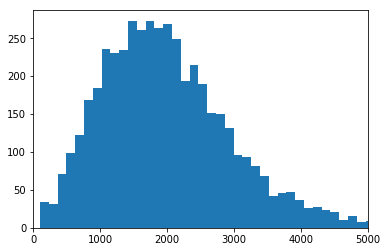

In [952]:
pyplot.hist(helaMergeMetaCleanFTransLen['len'], bins=100)
plt.xlim(0,5000)

(0, 5000)

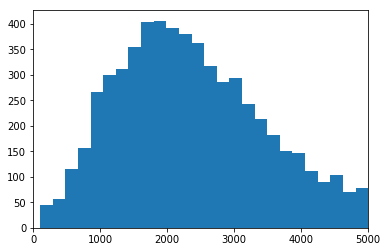

In [953]:
pyplot.hist(helaMergeMetaCleanW5TransLen['len'], bins=100)
plt.xlim(0,5000)

In [240]:
# Collapse Meta Transcripts

In [950]:
importlib.reload(MetaCoverage)

helaMerge_mergeScaleMetaCovDict = MetaCoverage.MetaCoverage.get_scaled_metacoverage_vectors(hela_merge_gene_protCodingMetaCoverage)
helaMerge_mergeScaleMetaCovW5Dict = MetaCoverage.MetaCoverage.get_scaled_metacoverage_vectors(hela_merge_gene_protCodingMetaCoverageW5)

/home/jalles/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jalles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [951]:
# Set Higher Filter

helaMerge_mergeScaleMetaCovDictF = MetaCoverage.MetaCoverage.get_scaled_metacoverage_vectors(hela_merge_gene_protCodingMetaCoverageF)
helaMerge_mergeScaleMetaCovW5DictF = MetaCoverage.MetaCoverage.get_scaled_metacoverage_vectors(hela_merge_gene_protCodingMetaCoverageW5F)

/home/jalles/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jalles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [843]:
def writeMetaCoverageDict(metaCoverageDict, outPaht):
    
    with open(outPaht, 'w') as out:
        for g, meta in metaCoverageDict.items():
            outLine = g + '\t' + '\t'.join([str(m) for m in meta.tolist()]) + '\n'
            out.write(outLine)

In [954]:
# Write MetaCoverage Vectors to file, along gene length bins

writeMetaCoverageDict(helaMerge_mergeScaleMetaCovDict,
                      '/data/rajewsky/home/jaLLLes/projects/GItailing/MetaCoverage/MetaCoverageMatrix/HeLaMergeScaledMetacoverage.txt')
writeMetaCoverageDict(helaMerge_mergeScaleMetaCovW5Dict,
                      '/data/rajewsky/home/jaLLLes/projects/GItailing/MetaCoverage/MetaCoverageMatrix/HeLaMergeScaledW5Metacoverage.txt')

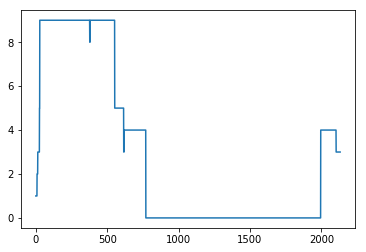

In [956]:
plt.plot(hela_merge_gene_protCodingMetaCoverageW5['C12orf45'])

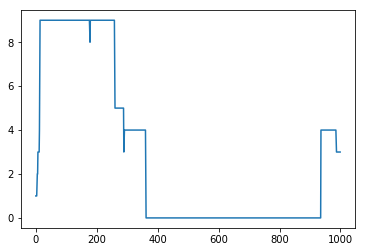

In [957]:
plt.plot(helaMerge_mergeScaleMetaCovDict['C12orf45'])

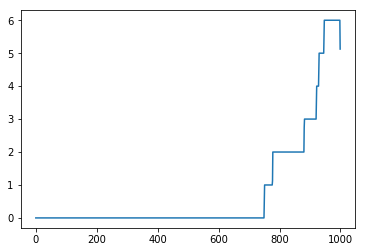

In [958]:
plt.plot(helaMerge_mergeScaleMetaCovW5Dict['ERBB3'])

In [600]:
def computeGeneLengthBin(gene_len_df, nbins):
    # Define Quantile Boundaried from bnins
    # Define numpy linspace
    qSpace = np.linspace(0,1,nbins+1)
    qSpace = qSpace[1:]
    # Get genes for intervals in qSpace
    qLow = 0
    
    geneQuantL = []
    
    for q in qSpace:
        qHigh = gene_len_df['len'].quantile(q=q)
        
        # Select genes with len < gHigh and > qLow
        f = (gene_len_df['len'] < qHigh) & (gene_len_df['len']>qLow)
        
        geneQuant = gene_len_df[f]['gene'].tolist()
        geneQuantL.append(geneQuant)
        qLow = qHigh
    
    return geneQuantL
    
def getScaleMetacoverageSumLenBin(sample_mergeScaleMetacovDict, 
                                  lenBinGenesL, 
                                  normalizeByMax = False):
    
    binCovSumL = []
    
    for genes in lenBinGenesL:
        
        cv_vec = np.zeros(1000)
        for g in genes:
            cv_vec += sample_mergeScaleMetacovDict[g]
        
        if normalizeByMax:
            # Smooth Vector first
            cv_vec = pd.DataFrame(cv_vec).rolling(25).mean()
            cv_vec = cv_vec / np.max(cv_vec)
        
        binCovSumL.append(cv_vec)
        
    return binCovSumL

def getScaleMetacoverageGeneAvLenBin(sample_mergeScaleMetacovDict, 
                                        lenBinGenesL, 
                                      normalizeByMax = False):
    
    binCovSumL = []
    
    for genes in lenBinGenesL:
        
        cv_vec = np.zeros(1000)
        for g in genes:
            g_cv_vec = sample_mergeScaleMetacovDict[g]
            g_cv_vec = g_cv_vec / np.max(g_cv_vec)
            cv_vec += g_cv_vec
        
        if normalizeByMax:
            # Smooth Vector first
            cv_vec = pd.DataFrame(cv_vec).rolling(25).mean()
            cv_vec = cv_vec / np.max(cv_vec)
        
        binCovSumL.append(cv_vec)
        
    return binCovSumL



def plotCoverageBins(coverageBinList, smooth=False):
    leg = []
    
    for binN, covBin in enumerate(coverageBinList):
        
        leg.append(str(binN))
        covBin = pd.DataFrame(covBin)
        
        if smooth:
            covBin = covBin.rolling(25).mean()
        
        plt.plot(covBin)
    plt.legend(leg)
    plt.show()

In [959]:
geneLenQuant = computeGeneLengthBin(helaMergeMetaCleanTransLen, 4)
geneLenQuantW5 = computeGeneLengthBin(helaMergeMetaCleanW5TransLen, 4)

geneLenBinCovSum = getScaleMetacoverageSumLenBin(helaMerge_mergeScaleMetaCovDict, geneLenQuant)
geneLenBinCovSumW5 = getScaleMetacoverageSumLenBin(helaMerge_mergeScaleMetaCovW5Dict, geneLenQuantW5)

In [960]:
geneLenBinCovSumN = getScaleMetacoverageSumLenBin(helaMerge_mergeScaleMetaCovDict, geneLenQuant, normalizeByMax=True)
geneLenBinCovSumW5N = getScaleMetacoverageSumLenBin(helaMerge_mergeScaleMetaCovW5Dict, geneLenQuantW5, normalizeByMax=True)

## Plot Absolute Counts across all genes

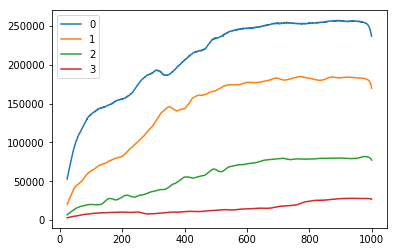

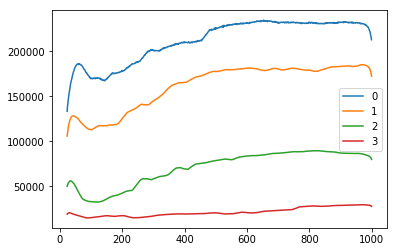

In [983]:
plotCoverageBins(geneLenBinCovSumW5, smooth=True)
plotCoverageBins(geneLenBinCovSum, smooth=True)


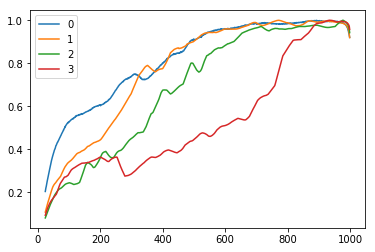

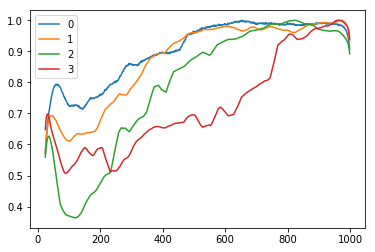

In [962]:
plotCoverageBins(geneLenBinCovSumW5N, smooth=False)
plotCoverageBins(geneLenBinCovSumN, smooth=False)


### Plot Abs Counts for filtered datasets


In [963]:
geneLenQuantF = computeGeneLengthBin(helaMergeMetaCleanFTransLen, 4)
geneLenQuantW5F = computeGeneLengthBin(helaMergeMetaCleanW5FTransLen, 4)

In [964]:
geneLenBinCovSumF = getScaleMetacoverageSumLenBin(helaMerge_mergeScaleMetaCovDictF, geneLenQuantF)
geneLenBinCovSumW5F = getScaleMetacoverageSumLenBin(helaMerge_mergeScaleMetaCovW5DictF, geneLenQuantW5F)

In [965]:
geneLenBinCovSumFN = getScaleMetacoverageSumLenBin(helaMerge_mergeScaleMetaCovDictF, geneLenQuantF, normalizeByMax=True)
geneLenBinCovSumFW5N = getScaleMetacoverageSumLenBin(helaMerge_mergeScaleMetaCovW5DictF, geneLenQuantW5F, normalizeByMax=True)

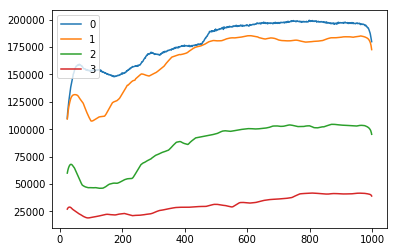

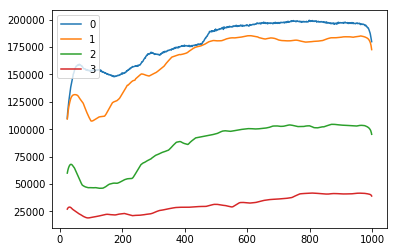

In [966]:
plotCoverageBins(geneLenBinCovSumF, smooth=True)
plotCoverageBins(geneLenBinCovSumW5F, smooth=True)

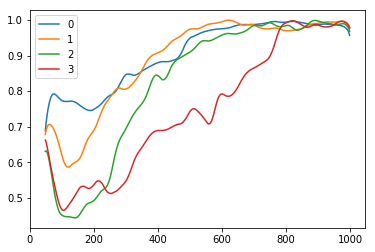

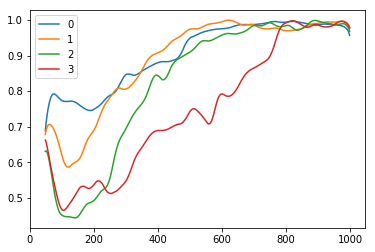

In [967]:
plotCoverageBins(geneLenBinCovSumFN, smooth=True)
plotCoverageBins(geneLenBinCovSumFW5N, smooth=True)

### Plot Normalization for each gene

In [968]:
geneLenBinCovGAv = getScaleMetacoverageGeneAvLenBin(helaMerge_mergeScaleMetaCovDict, geneLenQuant)
geneLenBinCovGAvW5 = getScaleMetacoverageGeneAvLenBin(helaMerge_mergeScaleMetaCovW5Dict, geneLenQuantW5)

In [969]:
geneLenBinCovGAvN = getScaleMetacoverageGeneAvLenBin(helaMerge_mergeScaleMetaCovDict, geneLenQuant, normalizeByMax=True)
geneLenBinCovGAvW5N = getScaleMetacoverageGeneAvLenBin(helaMerge_mergeScaleMetaCovW5Dict, geneLenQuantW5, normalizeByMax=True)

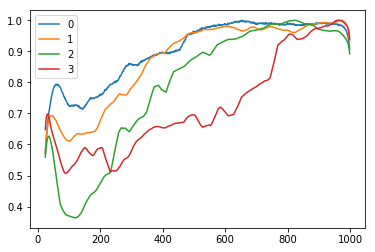

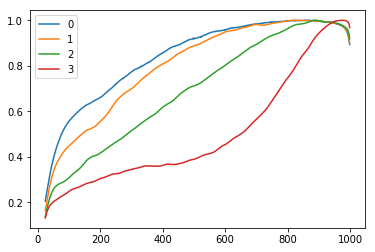

In [970]:
plotCoverageBins(geneLenBinCovSumN, smooth=False)
plotCoverageBins(geneLenBinCovGAvW5N, smooth=False)

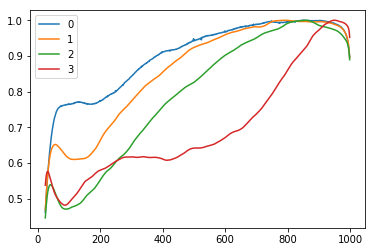

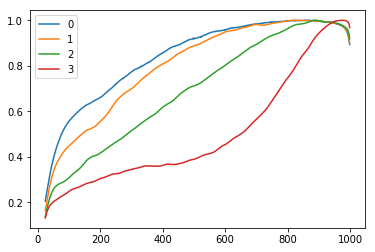

In [971]:
plotCoverageBins(geneLenBinCovGAvN, smooth=False)
plotCoverageBins(geneLenBinCovGAvW5N, smooth=False)

### Plot Gene Wise DropOff for filtered Dataset

In [972]:
geneLenBinCovGAvF = getScaleMetacoverageGeneAvLenBin(helaMerge_mergeScaleMetaCovDictF, geneLenQuantF)
geneLenBinCovGAvW5F = getScaleMetacoverageGeneAvLenBin(helaMerge_mergeScaleMetaCovW5DictF, geneLenQuantW5F)

In [973]:
geneLenBinCovGAvFN = getScaleMetacoverageGeneAvLenBin(helaMerge_mergeScaleMetaCovDictF, geneLenQuantF, normalizeByMax=True)
geneLenBinCovGAvW5FN = getScaleMetacoverageGeneAvLenBin(helaMerge_mergeScaleMetaCovW5DictF, geneLenQuantW5F, normalizeByMax=True)

X.shape

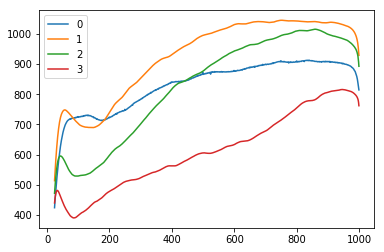

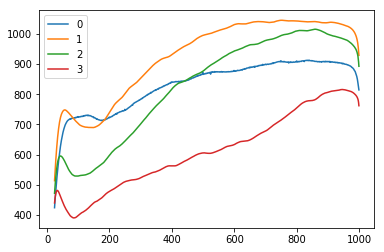

In [974]:
plotCoverageBins(geneLenBinCovGAvF, smooth=True)
plotCoverageBins(geneLenBinCovGAvW5F, smooth=True)

In [11]:
plotCoverageBins(geneLenBinCovGAvFN, smooth=False)
plotCoverageBins(geneLenBinCovGAvW5FN, smooth=False)

NameError: name 'plotCoverageBins' is not defined

### Plot Metacoverage for each bin w/o normlaization

Leave out normalizations

In [856]:
def getMetacoverageSum(sample_mergeScaleMetacovDict, lenBinGenesL, outEle = 2500):
    
    covSumL = []
    
    for genes in lenBinGenesL:
        
        binCovSum = np.zeros(outEle)
        
        for g in genes:
            gMetaCov = sample_mergeScaleMetacovDict[g]
            gMetaLen = len(gMetaCov)
            
            if gMetaLen > outEle:
                binCovSum += gMetaCov[-outEle:]
            else:
                binCovSum[outEle-gMetaLen:] += gMetaCov
        
        covSumL.append(binCovSum)
    return(covSumL)


def getMetacoverageGAv(sample_mergeScaleMetacovDict, lenBinGenesL, outEle = 2500):
    
    covSumL = []
    
    for genes in lenBinGenesL:
        
        binCovSum = np.zeros(outEle)
        
        for g in genes:
            gMetaCov = sample_mergeScaleMetacovDict[g]
            
            # Normalize each position of coverage by rolling mean max
            gMetaCovMax = pd.DataFrame(gMetaCov).rolling(25).mean().max()            
            gMetaCov = gMetaCov / gMetaCovMax.tolist()[0]
            
            gMetaLen = len(gMetaCov)
            
            if gMetaLen > outEle:
                binCovSum += gMetaCov[-outEle:]
            else:
                binCovSum[outEle-gMetaLen:] += gMetaCov
        
        covSumL.append(binCovSum)
    return(covSumL)


In [976]:
geneLenBinSum = getMetacoverageSum(hela_merge_gene_protCodingMetaCoverage, geneLenQuant, outEle=10000)
geneLenBinSumW5 = getMetacoverageSum(hela_merge_gene_protCodingMetaCoverageW5, geneLenQuantW5, outEle=10000)

In [977]:
geneLenBinAvN = getMetacoverageGAv(hela_merge_gene_protCodingMetaCoverage, geneLenQuant, outEle=10000)
geneLenBinAvW5N = getMetacoverageGAv(hela_merge_gene_protCodingMetaCoverageW5, geneLenQuantW5, outEle=10000)

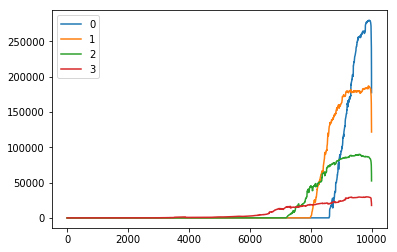

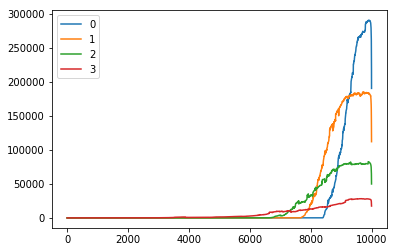

In [978]:
plotCoverageBins(geneLenBinSum)
plotCoverageBins(geneLenBinSumW5)

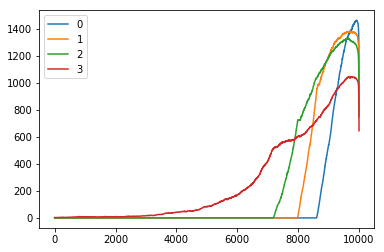

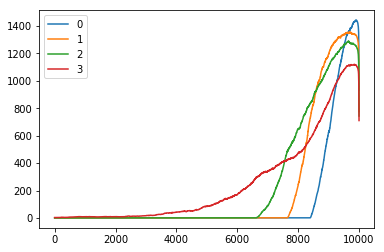

In [979]:
plotCoverageBins(geneLenBinAvN)
plotCoverageBins(geneLenBinAvW5N)

hela_merge_gene_protCodingMetaCoverageW5

helaMergeMetaCleanW5TransLen

In [753]:
# Compute MetaCoverage Bin

def computeMetaDfAverages(sampleMetaCoverage, 
                          geneTransLenDf, 
                          outEle = 5000):
    # for each gene compute relative coverage and write to matrix
    outMat = pd.DataFrame(np.zeros([len(sampleMetaCoverage), outEle]))
    
    for rInd, g in enumerate(geneTransLenDf['gene'].tolist()):
    
        meta = sampleMetaCoverage[g]

        metaDf = pd.DataFrame(meta)

        metaDfMax = metaDf.rolling(25).mean().max()
        metaDf = metaDf / metaDfMax
        
        if len(metaDf) <= outEle:
            # Add zeros
            zDf = pd.DataFrame(np.zeros(outEle - len(metaDf)))
            metaDf = zDf.append(metaDf)
        else:
            metaDf = metaDf.iloc[-outEle:,]
        metaDf = metaDf.reset_index(drop=True)
        outMat.iloc[rInd,:] = metaDf.iloc[:,0]
    
    return outMat



def computeMetaDfSums(sampleMetaCoverage, 
                          geneTransLenDf, 
                          outEle = 5000):
    # for each gene compute relative coverage and write to matrix
    outMat = pd.DataFrame(np.zeros([len(sampleMetaCoverage), outEle]))
    
    posCounts = np.zeros(outEle)
    
    for rInd, g in enumerate(geneTransLenDf['gene'].tolist()):
    
        meta = sampleMetaCoverage[g]

        metaDf = pd.DataFrame(meta)

        if len(metaDf) <= outEle:
            # Add zeros
            zDf = pd.DataFrame(np.zeros(outEle - len(metaDf)))
            metaDf = zDf.append(metaDf)
            posCounts[-len(metaDf):] += 1
        else:
            metaDf = metaDf.iloc[-outEle:,]
            posCounts[-len(metaDf):] += 1
        metaDf = metaDf.reset_index(drop=True)
        outMat.iloc[rInd,:] = metaDf.iloc[:,0]
    
    return outMat

def write

In [10]:
hela_merge_gene_protCodingW5_absCov=computeMetaDfAverages(hela_merge_gene_protCodingMetaCoverageW5,
                                                          helaMergeMetaCleanW5TransLen, outEle=5000)

NameError: name 'computeMetaDfAverages' is not defined

In [9]:
hela_merge_gene_protCodingW5_absCov.to_csv('/data/rajewsky/home/jaLLLes/projects/GItailing/MetaCoverage/MetaCoverageMatrix/HeLaMergeMetaAvCovMeta.csv',
                                          index=None)

NameError: name 'hela_merge_gene_protCodingW5_absCov' is not defined

In [4]:
hela_merge_gene_protCodingW5_absCov = pd.read_csv('/data/rajewsky/home/jaLLLes/projects/GItailing/MetaCoverage/MetaCoverageMatrix/HeLaMergeMetaAvCovMeta.csv')

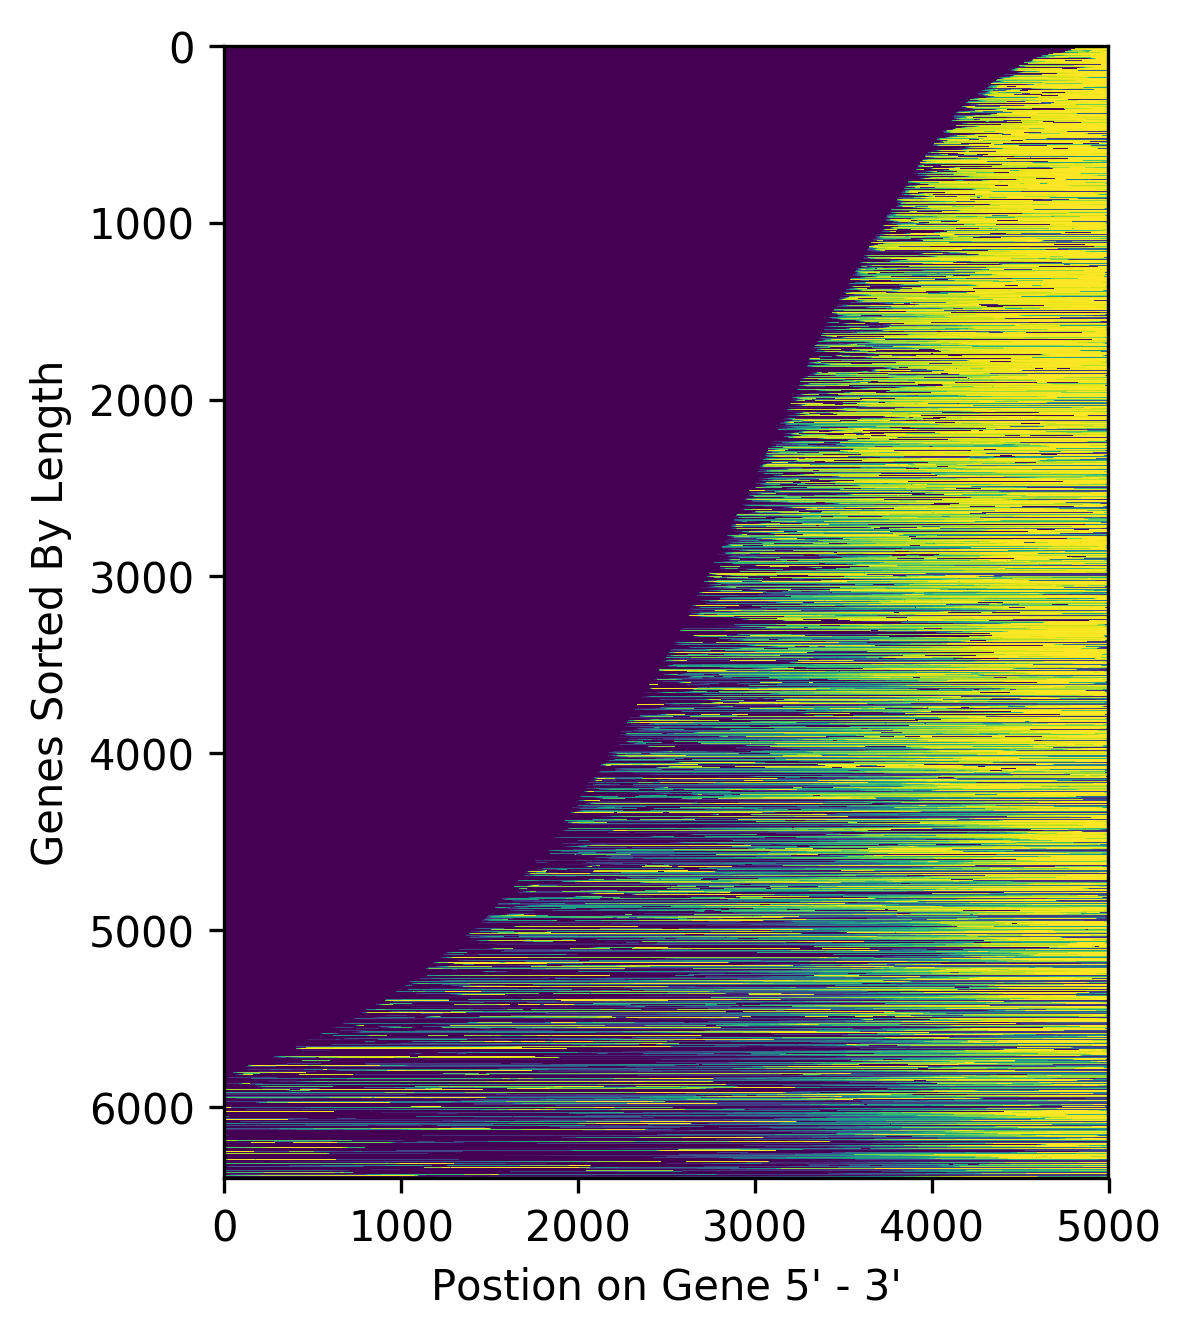

In [19]:
#plt.imshow(hela_merge_gene_protCoding_absCov, vmin=0, vmax=1)

plt.figure(figsize=(5,5), dpi=300)
plt.imshow(hela_merge_gene_protCodingW5_absCov, vmin=0, vmax=1)
plt.xlabel('Postion on Gene 5\' - 3\'')
plt.ylabel('Genes Sorted By Length')
plt.savefig('/data/rajewsky/home/jaLLLes/projects/GItailing/MetaCoverage/HeLaMetaAvCovMetaHeat.png', dpi=300)
plt.savefig('/data/rajewsky/home/jaLLLes/projects/GItailing/MetaCoverage/HeLaMetaAvCovMetaHeat.svg', dpi=300, format="svg")

plt.savefig('/data/murphy/home/jalles/projects/GItailing/gi_tailing_r/FLAMSeqRevisionNM/plots_manuscript/fig_s1/HeLaMetaAvCovMetaHeat.png', dpi=300)
plt.savefig('/data/murphy/home/jalles/projects/GItailing/gi_tailing_r/FLAMSeqRevisionNM/plots_manuscript/fig_s1/HeLaMetaAvCovMetaHeat.svg', dpi=300, format="svg")

Repeat with expression filtered matrices

In [754]:
hela_merge_gene_protCodingW5_SumCov=computeMetaDfSums(hela_merge_gene_protCodingMetaCoverageW5,
                                                          helaMergeMetaCleanW5TransLen, outEle=5000)
hela_merge_gene_protCoding_SumCov=computeMetaDfSums(hela_merge_gene_protCodingMetaCoverage, 
                                                        helaMergeMetaCleanTransLen, outEle=5000)

KeyboardInterrupt: 

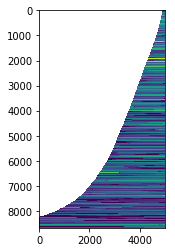

In [755]:
plt.imshow(hela_merge_gene_protCoding_SumCov.apply(np.log2), vmin=0)

In [ ]:
# Get MetaCoverage Matrix cleaned MetaExon dict


In [195]:
importlib.reload(MetaCoverage)

hela_merge_gene_scale_protCodingClean = MetaCoverage.MetaCoverage.generate_scale_metacoverage_dict(helaMerge_CleanMetaExonDict)

ValueError: zero-size array to reduction operation maximum which has no identity

In [184]:
len(hela_merge_gene_scale_protCoding['GAPDH']

1000

#### Write Metacoverage Matrices

In [ ]:
importlib.reload(MetaCoverage)

MetaCoverage.MetaCoverage.get_metacoverage_matrix(gencode_hg38_exons_bed_path,
                                                 hela_merge_bam_path,
                                                 min_cov_per_single_pos = 5,
                                                 matrix_path = '/data/murphy/home/jalles/projects/GItailing/MetaCoverage/HeLa_merge_MetaCoverage.txt')

In [11]:
importlib.reload(MetaCoverage)

MetaCoverage.MetaCoverage.get_metacoverage_matrix(gencode_hg38_protCoding_exons_bed_path,
                                                 hela_merge_genomic_clean_bam_path,
                                                 min_cov_per_single_pos = 5,
                                                 matrix_path = '/data/murphy/home/jalles/projects/GItailing/MetaCoverage/HeLa_merge_protCoding_MetaCoverage.txt')

/home/jalles/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jalles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
importlib.reload(MetaCoverage)

MetaCoverage.MetaCoverage.get_metacoverage_matrix(gencode_hg38_exons_bed_path,
                                                 ipsc_merge_bam_path,
                                                 min_cov_per_single_pos = 5,
                                                 matrix_path = '/data/murphy/home/jalles/projects/GItailing/MetaCoverage/iPSC_merge_MetaCoverage.txt')

In [ ]:
importlib.reload(MetaCoverage)

MetaCoverage.MetaCoverage.get_metacoverage_matrix(gencode_hg38_exons_bed_path,
                                                 org_d30_merge_bam_path,
                                                 min_cov_per_single_pos = 5,
                                                 matrix_path = '/data/murphy/home/jalles/projects/GItailing/MetaCoverage/Org_d30_merge_MetaCoverage.txt')

In [ ]:
# Define C Elegans Merge Data
c_ele_exons_bed_path = '/data/murphy/home/jalles/projects/GItailing/annotation/c_elegans_canonical_geneset_exon.bed'
c_ele_egglay_merge_bam_path = '/data/murphy/home/jalles/projects/GItailing/Data/merge_datasets/NR_IL_Pb-18-20_merge.bam'
c_ele_L4_merge_bam_path = '/data/murphy/home/jalles/projects/GItailing/Data/merge_datasets/NR_IL_Pb-19-21_merge.bam'

In [ ]:
importlib.reload(MetaCoverage)

MetaCoverage.MetaCoverage.get_metacoverage_matrix(c_ele_exons_bed_path,
                                                 c_ele_egglay_merge_bam_path,
                                                 min_cov_per_single_pos = 5,
                                                 matrix_path = '/data/murphy/home/jalles/projects/GItailing/MetaCoverage/c_ele_egglay_merge_MetaCoverage.txt')

In [ ]:
importlib.reload(MetaCoverage)

MetaCoverage.MetaCoverage.get_metacoverage_matrix(c_ele_exons_bed_path,
                                                 c_ele_L4_merge_bam_path,
                                                 min_cov_per_single_pos = 5,
                                                 matrix_path = '/data/murphy/home/jalles/projects/GItailing/MetaCoverage/c_ele_L4_merge_MetaCoverage.txt')